In [47]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

from keras import backend as K
img_dim_ordering = 'tf'
K.set_image_dim_ordering(img_dim_ordering)

import numpy as np

In [48]:
from util import *

In [49]:
data_dir = 'data'

In [50]:
X_train_imgs_filename = '%s/X_train_imgs.csv' % data_dir
X_val_imgs_filename = '%s/X_val_imgs.csv' % data_dir
X_test_imgs_filename = '%s/X_test_imgs.csv' % data_dir
y_train_filename = '%s/y_train.csv' % data_dir
y_val_filename = '%s/y_val.csv' % data_dir
y_test_filename = '%s/y_test.csv' % data_dir

In [51]:
X_train_img_files = read_img_file_csv(X_train_imgs_filename)
X_val_img_files = read_img_file_csv(X_val_imgs_filename)
X_test_img_files = read_img_file_csv(X_test_imgs_filename)
y_train = read_label_file_csv(y_train_filename)
y_val = read_label_file_csv(y_val_filename)
y_test = read_label_file_csv(y_test_filename)

In [52]:
def pretrained_model(img_shape, num_classes, activation='relu', n=4096, lr=0.001):
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    for layer in model_vgg16_conv.layers:
        layer.trainable = False
        
    #model_vgg16_conv.summary()
    
    #Create your own input format
    keras_input = Input(shape=img_shape, name = 'image_input')
    
    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(keras_input)
    
    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(n, activation=activation, name='fc1')(x)
    x = Dense(n, activation=activation, name='fc2')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    #Create your own model 
    pretrained_model = Model(inputs=keras_input, outputs=x)
    optimizer = Adam(lr=lr)
    pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', 
                             metrics=['accuracy'])
    
    return pretrained_model

In [53]:
X_train_imgs = read_imgs(X_train_img_files, scale_to_255=True)
X_train_imgs.shape

(12432, 64, 64, 3)

In [54]:
X_train_img_files[:5]

['data/non-vehicles/GTI/image1314.png',
 'data/non-vehicles/GTI/image1630.png',
 'data/non-vehicles/GTI/image1838.png',
 'data/non-vehicles/GTI/image3168.png',
 'data/vehicles/KITTI_extracted/3822.png']

In [55]:
def vgg_load_imgs(X_img_files):
    X_img_arr = []
    for img_path in tqdm(X_img_files):
        #print(img_path)
        curr_img = image.load_img(img_path, target_size=(64, 64))
        X_img_arr.append(curr_img.copy())
        curr_img.close()

    X_imgs = np.stack(X_img_arr)    
    
    return X_imgs.astype(np.float32)/255.0

In [56]:
X_train_img_files, y_train = shuffle_train_data(X_train_img_files, y_train)

cutoff = int(0.1*len(y_train))
_X_train_img_files = X_train_img_files[:cutoff]
_y_train = y_train[:cutoff]

_X_train = vgg_load_imgs(_X_train_img_files)
_X_train.shape

In [57]:
X_train = vgg_load_imgs(X_train_img_files)
X_train.shape

100%|██████████████████████████████████████████████████████████████████████████| 12432/12432 [00:02<00:00, 4282.47it/s]


(12432, 64, 64, 3)

In [58]:
X_train[0].min(), X_train[0].max()

(0.035294119, 1.0)

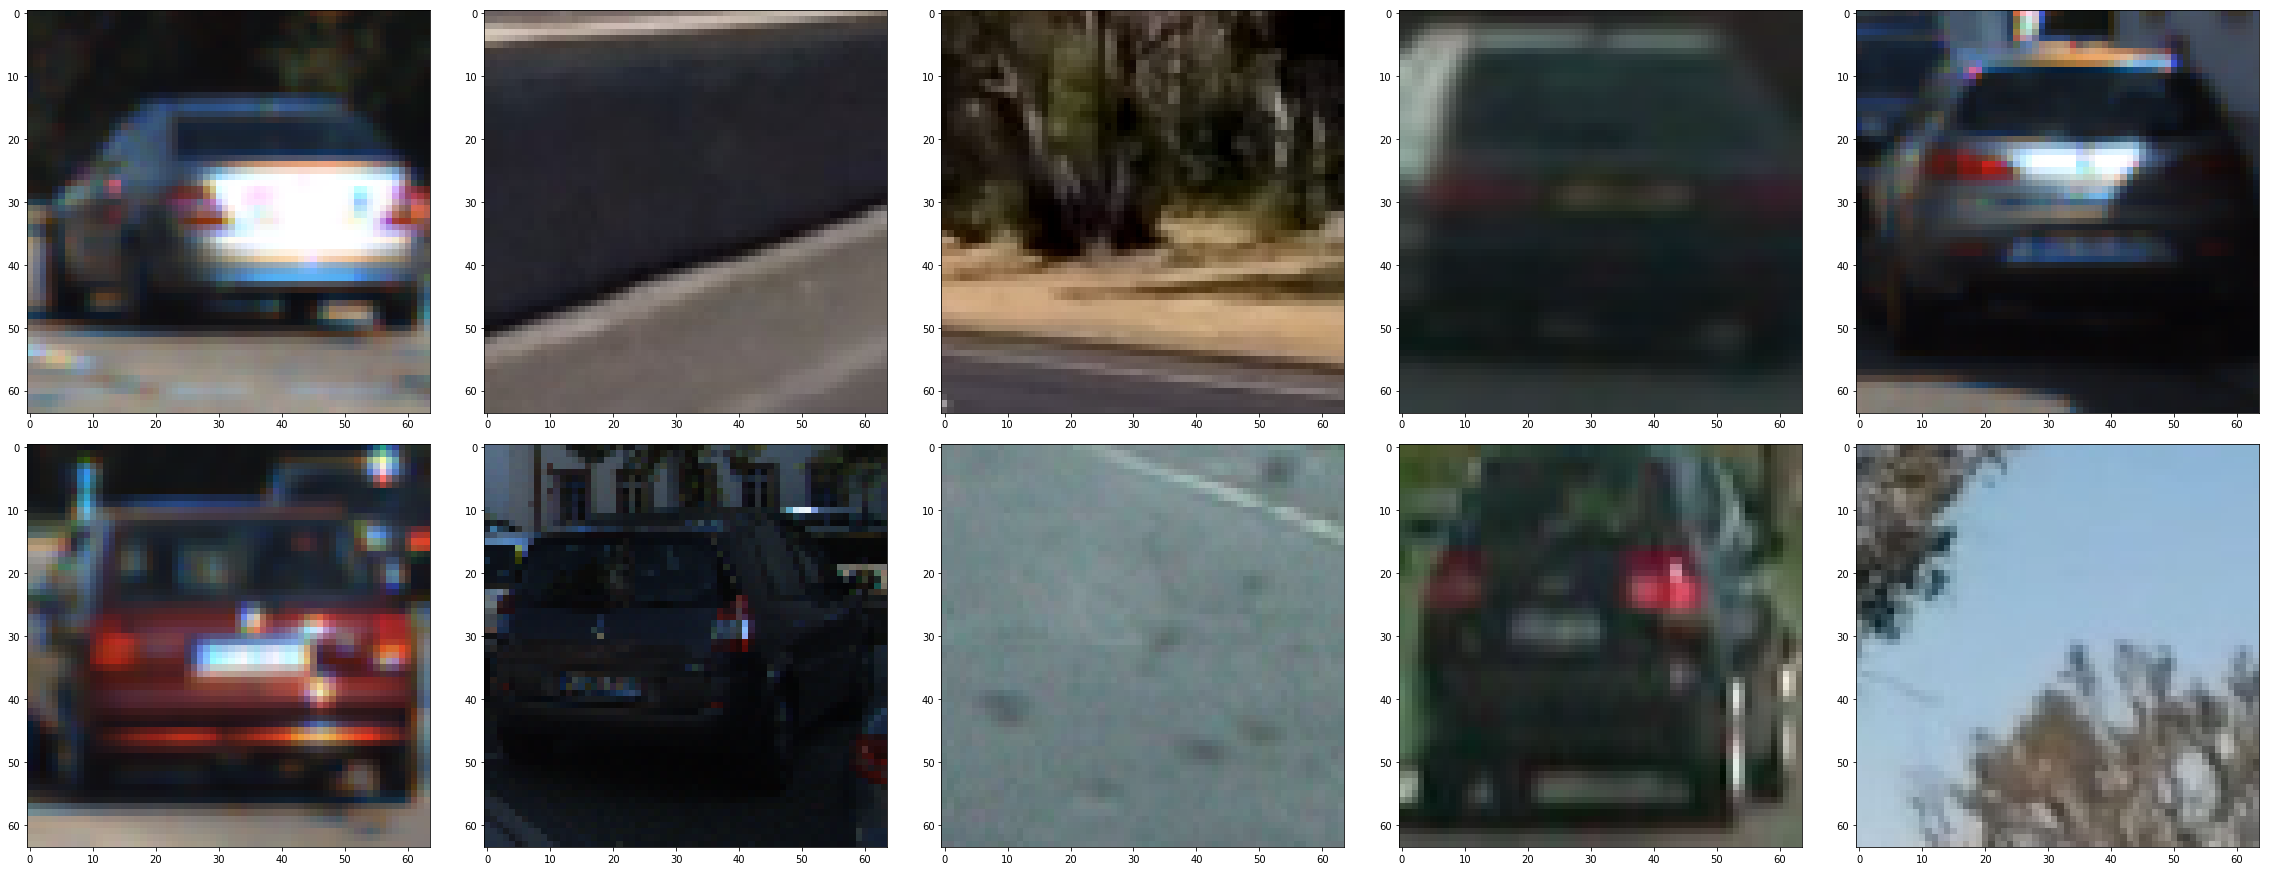

In [59]:
display_images(X_train, start_idx=0, end_idx=10)

In [60]:
X_val = vgg_load_imgs(X_val_img_files)
X_val.shape

100%|████████████████████████████████████████████████████████████████████████████| 3569/3569 [00:00<00:00, 4320.83it/s]


(3569, 64, 64, 3)

In [61]:
X_test = vgg_load_imgs(X_test_img_files)
X_test.shape

100%|████████████████████████████████████████████████████████████████████████████| 1759/1759 [00:00<00:00, 4311.32it/s]


(1759, 64, 64, 3)

In [82]:
model = pretrained_model((64, 64, 3), 2, n=512, lr=0.0001)

In [83]:
model_file = '%s/model.h5' % data_dir

In [84]:
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=2,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)
callbacks = [checkpoint]        

In [85]:
model.fit(x=X_train, y=np.array(y_train), batch_size=32, epochs=20, verbose=2, callbacks=callbacks, 
          validation_data=(X_val, np.array(y_val)), shuffle=True, initial_epoch=0)

Train on 12432 samples, validate on 3569 samples
Epoch 1/20

Epoch 00001: val_loss improved from inf to 0.02230, saving model to data/model.h5
 - 8s - loss: 0.0582 - acc: 0.9769 - val_loss: 0.0223 - val_acc: 0.9922
Epoch 2/20

Epoch 00002: val_loss did not improve
 - 8s - loss: 0.0211 - acc: 0.9925 - val_loss: 0.0234 - val_acc: 0.9922
Epoch 3/20

Epoch 00003: val_loss improved from 0.02230 to 0.01325, saving model to data/model.h5
 - 8s - loss: 0.0118 - acc: 0.9964 - val_loss: 0.0133 - val_acc: 0.9947
Epoch 4/20

Epoch 00004: val_loss did not improve
 - 8s - loss: 0.0155 - acc: 0.9949 - val_loss: 0.0144 - val_acc: 0.9941
Epoch 5/20

Epoch 00005: val_loss did not improve
 - 8s - loss: 0.0102 - acc: 0.9972 - val_loss: 0.0221 - val_acc: 0.9933
Epoch 6/20

Epoch 00006: val_loss did not improve
 - 8s - loss: 0.0127 - acc: 0.9959 - val_loss: 0.0242 - val_acc: 0.9927
Epoch 7/20

Epoch 00007: val_loss improved from 0.01325 to 0.00917, saving model to data/model.h5
 - 8s - loss: 0.0051 - acc: 0

In [67]:
model = load_model(model_file)

In [68]:
model.evaluate(X_test, np.array(y_test))

1759/1759 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 505us/step


[0.011254984372025547, 0.99658897100625354]

In [89]:
9.99999881e-01

0.999999881

In [86]:
model.predict(X_test[10:20])

array([[  9.99999881e-01,   1.44283192e-07],
       [  2.54829710e-14,   1.00000000e+00],
       [  2.03948614e-34,   1.00000000e+00],
       [  2.79581458e-12,   1.00000000e+00],
       [  1.01236526e-18,   1.00000000e+00],
       [  1.00000000e+00,   1.16249623e-08],
       [  6.59436157e-23,   1.00000000e+00],
       [  1.00000000e+00,   8.83507989e-11],
       [  1.37571844e-25,   1.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00]], dtype=float32)

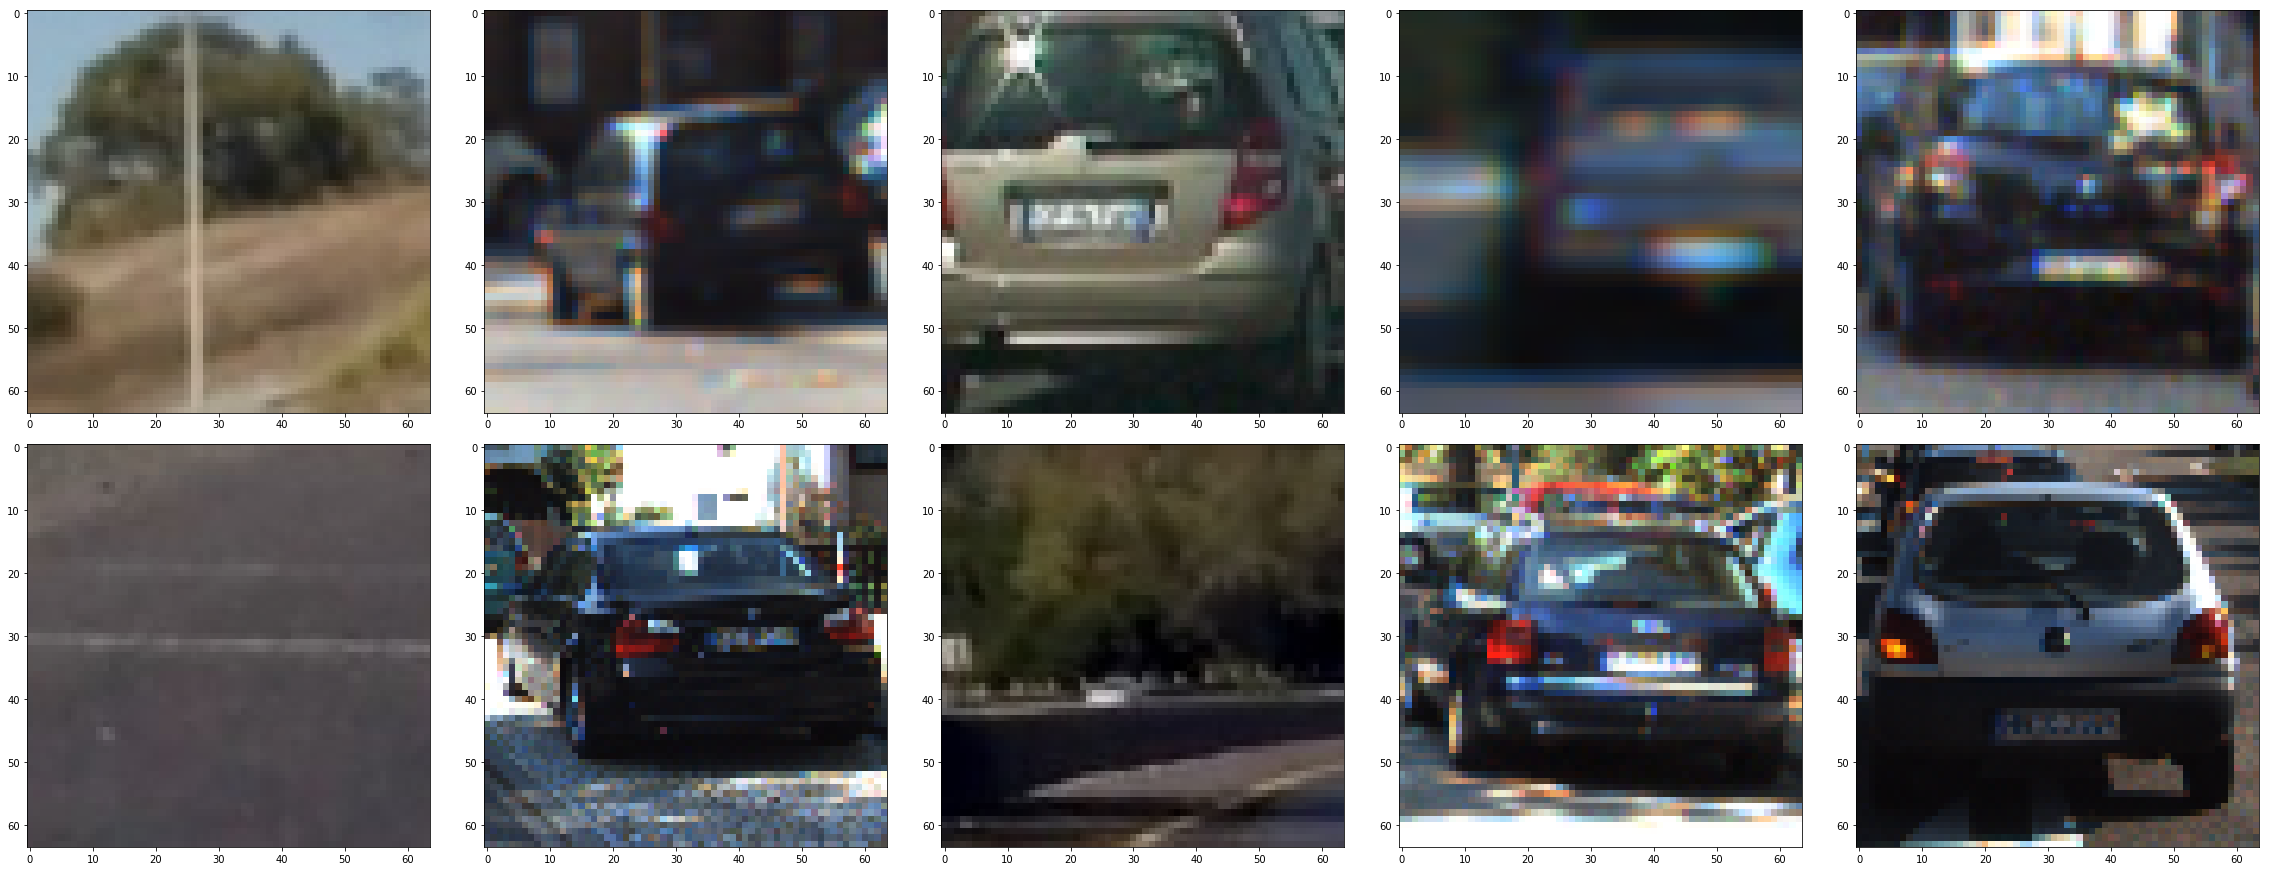

In [87]:
display_images(X_test[10:20])

# Search

In [ ]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            print("### ys:", ys)
            print("### xs:", xs)
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            print("((%d, %d), (%d, %d))" % startx, endx)
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

In [ ]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        
    # Return the image copy with boxes drawn
    return imcopy

In [ ]:
def single_img_features(img):
    return img

In [ ]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, model):    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        
        #5) Scale extracted features to be fed to classifier
        test_features = np.array(features).reshape(1, -1)
        
        #6) Predict using your classifier
        prediction = model.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows

In [ ]:
image = read_img('test_images/test1.jpg', scale_to_255=False)

In [ ]:
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, best_clf, 
                             spatial_feature_scaler, hist_feature_scaler, hog_feature_scalers,
                             color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                             hist_range=hist_range, orient=hog_orient, 
                             pix_per_cell=hog_pix_per_cell, cell_per_block=hog_cell_per_block)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)